In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest26d'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 90
    epochs_patience = 12

    lr = 1e-4
    loss = "DiceLoss"

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(p=1),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



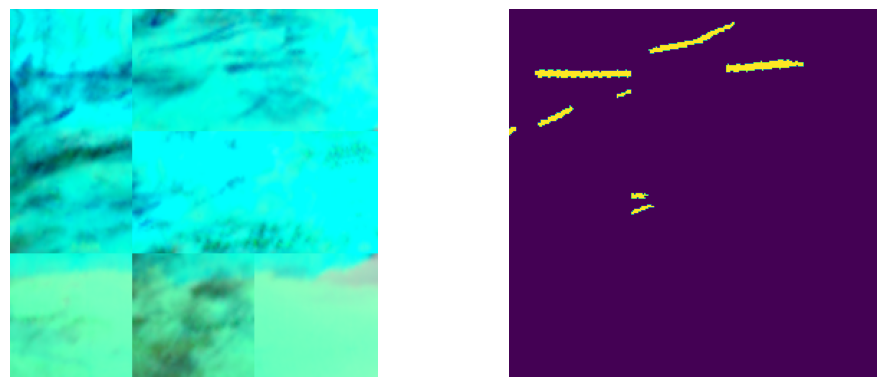

In [5]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(112, dataset_train)

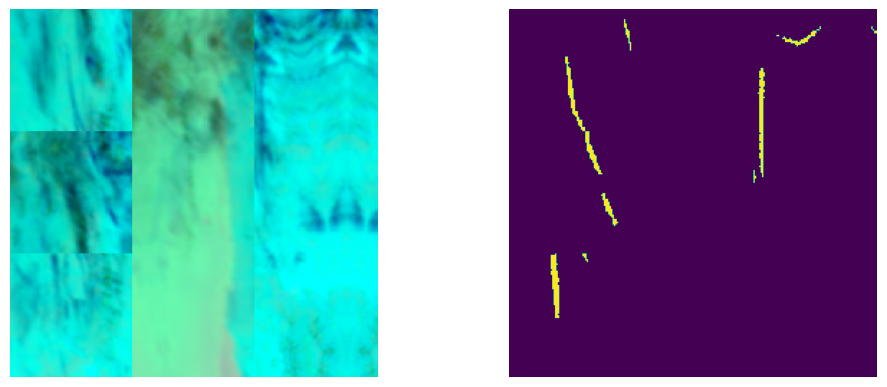

In [6]:
show_dataset(112, dataset_train)

# Model

In [7]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  timm-resnest26d


In [8]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [9]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(CFG.epochs):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
        
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/90  Mem : 7.79GB  LR : 1.00E-04  Loss: 0.8100: 100%|██████████| 642/642 [01:22<00:00,  7.82it/s]
Val Loss: 0.6815: 100%|██████████| 58/58 [00:04<00:00, 13.71it/s]


FBeta : 0.4981	thresh : 0.13	SAVED MODEL



Epoch 1/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.5387: 100%|██████████| 642/642 [01:20<00:00,  7.95it/s]
Val Loss: 0.5550: 100%|██████████| 58/58 [00:03<00:00, 16.43it/s]


FBeta : 0.4939	thresh : 0.51



Epoch 2/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4995: 100%|██████████| 642/642 [01:20<00:00,  7.95it/s]
Val Loss: 0.5364: 100%|██████████| 58/58 [00:03<00:00, 16.98it/s]


FBeta : 0.5010	thresh : 0.15	SAVED MODEL



Epoch 3/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4875: 100%|██████████| 642/642 [01:21<00:00,  7.92it/s]
Val Loss: 0.5390: 100%|██████████| 58/58 [00:03<00:00, 16.96it/s]


FBeta : 0.5053	thresh : 0.87	SAVED MODEL



Epoch 4/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4803: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.5064: 100%|██████████| 58/58 [00:03<00:00, 16.76it/s]


FBeta : 0.5295	thresh : 0.79	SAVED MODEL



Epoch 5/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4711: 100%|██████████| 642/642 [01:20<00:00,  7.95it/s]
Val Loss: 0.4909: 100%|██████████| 58/58 [00:03<00:00, 17.16it/s]


FBeta : 0.5424	thresh : 0.19	SAVED MODEL



Epoch 6/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4679: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.4888: 100%|██████████| 58/58 [00:03<00:00, 16.51it/s]


FBeta : 0.5505	thresh : 0.01	SAVED MODEL



Epoch 7/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4673: 100%|██████████| 642/642 [01:20<00:00,  8.00it/s]
Val Loss: 0.5013: 100%|██████████| 58/58 [00:03<00:00, 16.69it/s]


FBeta : 0.5301	thresh : 0.65



Epoch 8/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4626: 100%|██████████| 642/642 [01:20<00:00,  7.95it/s]
Val Loss: 0.5075: 100%|██████████| 58/58 [00:03<00:00, 16.66it/s]


FBeta : 0.5203	thresh : 0.31



Epoch 9/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4606: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4720: 100%|██████████| 58/58 [00:03<00:00, 16.81it/s]


FBeta : 0.5566	thresh : 0.27	SAVED MODEL



Epoch 10/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4553: 100%|██████████| 642/642 [01:20<00:00,  7.95it/s]
Val Loss: 0.5000: 100%|██████████| 58/58 [00:03<00:00, 17.04it/s]


FBeta : 0.5380	thresh : 0.35



Epoch 11/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4521: 100%|██████████| 642/642 [01:20<00:00,  7.98it/s]
Val Loss: 0.4677: 100%|██████████| 58/58 [00:03<00:00, 17.02it/s]


FBeta : 0.5614	thresh : 0.45	SAVED MODEL



Epoch 12/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4530: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4693: 100%|██████████| 58/58 [00:03<00:00, 16.85it/s]


FBeta : 0.5561	thresh : 0.07



Epoch 13/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4468: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4666: 100%|██████████| 58/58 [00:03<00:00, 16.96it/s]


FBeta : 0.5594	thresh : 0.61



Epoch 14/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4481: 100%|██████████| 642/642 [01:20<00:00,  7.95it/s]
Val Loss: 0.4665: 100%|██████████| 58/58 [00:03<00:00, 17.27it/s]


FBeta : 0.5621	thresh : 0.01	SAVED MODEL



Epoch 15/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4446: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4653: 100%|██████████| 58/58 [00:03<00:00, 16.83it/s]


FBeta : 0.5605	thresh : 0.05



Epoch 16/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4438: 100%|██████████| 642/642 [01:19<00:00,  8.11it/s]
Val Loss: 0.4581: 100%|██████████| 58/58 [00:03<00:00, 17.15it/s]


FBeta : 0.5704	thresh : 0.75	SAVED MODEL



Epoch 17/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4422: 100%|██████████| 642/642 [01:19<00:00,  8.12it/s]
Val Loss: 0.4562: 100%|██████████| 58/58 [00:03<00:00, 17.03it/s]


FBeta : 0.5685	thresh : 0.75



Epoch 18/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4439: 100%|██████████| 642/642 [01:19<00:00,  8.12it/s]
Val Loss: 0.4638: 100%|██████████| 58/58 [00:03<00:00, 17.17it/s]


FBeta : 0.5653	thresh : 0.99



Epoch 19/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4388: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4642: 100%|██████████| 58/58 [00:03<00:00, 17.14it/s]


FBeta : 0.5670	thresh : 0.01



Epoch 20/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4361: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4643: 100%|██████████| 58/58 [00:03<00:00, 16.91it/s]


FBeta : 0.5654	thresh : 0.01



Epoch 21/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4390: 100%|██████████| 642/642 [01:19<00:00,  8.11it/s]
Val Loss: 0.4730: 100%|██████████| 58/58 [00:03<00:00, 17.16it/s]


FBeta : 0.5506	thresh : 0.97



Epoch 22/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4371: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4452: 100%|██████████| 58/58 [00:03<00:00, 17.24it/s]


FBeta : 0.5791	thresh : 0.71	SAVED MODEL



Epoch 23/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4349: 100%|██████████| 642/642 [01:19<00:00,  8.12it/s]
Val Loss: 0.4499: 100%|██████████| 58/58 [00:03<00:00, 16.96it/s]


FBeta : 0.5773	thresh : 0.07



Epoch 24/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4354: 100%|██████████| 642/642 [01:19<00:00,  8.11it/s]
Val Loss: 0.4752: 100%|██████████| 58/58 [00:03<00:00, 17.11it/s]


FBeta : 0.5526	thresh : 0.93



Epoch 25/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4339: 100%|██████████| 642/642 [01:19<00:00,  8.11it/s]
Val Loss: 0.4687: 100%|██████████| 58/58 [00:03<00:00, 17.18it/s]


FBeta : 0.5675	thresh : 0.01



Epoch 26/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4286: 100%|██████████| 642/642 [01:19<00:00,  8.07it/s]
Val Loss: 0.4432: 100%|██████████| 58/58 [00:03<00:00, 16.99it/s]


FBeta : 0.5812	thresh : 0.85	SAVED MODEL



Epoch 27/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4316: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4603: 100%|██████████| 58/58 [00:03<00:00, 17.11it/s]


FBeta : 0.5690	thresh : 0.83



Epoch 28/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4294: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4517: 100%|██████████| 58/58 [00:03<00:00, 17.05it/s]


FBeta : 0.5744	thresh : 0.11



Epoch 29/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4286: 100%|██████████| 642/642 [01:19<00:00,  8.08it/s]
Val Loss: 0.4527: 100%|██████████| 58/58 [00:03<00:00, 15.12it/s]


FBeta : 0.5755	thresh : 0.65



Epoch 30/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4270: 100%|██████████| 642/642 [01:19<00:00,  8.08it/s]
Val Loss: 0.4481: 100%|██████████| 58/58 [00:03<00:00, 17.12it/s]


FBeta : 0.5803	thresh : 0.09



Epoch 31/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4232: 100%|██████████| 642/642 [01:19<00:00,  8.07it/s]
Val Loss: 0.4372: 100%|██████████| 58/58 [00:03<00:00, 17.03it/s]


FBeta : 0.5872	thresh : 0.01	SAVED MODEL



Epoch 32/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4285: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4416: 100%|██████████| 58/58 [00:03<00:00, 17.12it/s]


FBeta : 0.5843	thresh : 0.19



Epoch 33/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4231: 100%|██████████| 642/642 [01:19<00:00,  8.06it/s]
Val Loss: 0.4583: 100%|██████████| 58/58 [00:03<00:00, 16.95it/s]


FBeta : 0.5748	thresh : 0.67



Epoch 34/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4230: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4395: 100%|██████████| 58/58 [00:03<00:00, 16.96it/s]


FBeta : 0.5865	thresh : 0.49



Epoch 35/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4231: 100%|██████████| 642/642 [01:20<00:00,  7.98it/s]
Val Loss: 0.4363: 100%|██████████| 58/58 [00:03<00:00, 16.46it/s]


FBeta : 0.5904	thresh : 0.59	SAVED MODEL



Epoch 36/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4213: 100%|██████████| 642/642 [01:20<00:00,  7.98it/s]
Val Loss: 0.4437: 100%|██████████| 58/58 [00:03<00:00, 16.68it/s]


FBeta : 0.5840	thresh : 0.01



Epoch 37/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4214: 100%|██████████| 642/642 [01:20<00:00,  7.96it/s]
Val Loss: 0.4285: 100%|██████████| 58/58 [00:03<00:00, 16.80it/s]


FBeta : 0.5988	thresh : 0.01	SAVED MODEL



Epoch 38/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4190: 100%|██████████| 642/642 [01:20<00:00,  7.98it/s]
Val Loss: 0.4394: 100%|██████████| 58/58 [00:03<00:00, 16.56it/s]


FBeta : 0.5863	thresh : 0.01



Epoch 39/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4171: 100%|██████████| 642/642 [01:20<00:00,  8.02it/s]
Val Loss: 0.4359: 100%|██████████| 58/58 [00:03<00:00, 16.70it/s]


FBeta : 0.5914	thresh : 0.07



Epoch 40/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4179: 100%|██████████| 642/642 [01:20<00:00,  7.99it/s]
Val Loss: 0.4373: 100%|██████████| 58/58 [00:03<00:00, 16.72it/s]


FBeta : 0.5869	thresh : 0.03



Epoch 41/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4173: 100%|██████████| 642/642 [01:20<00:00,  7.97it/s]
Val Loss: 0.4517: 100%|██████████| 58/58 [00:03<00:00, 16.67it/s]


FBeta : 0.5791	thresh : 0.01



Epoch 42/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4167: 100%|██████████| 642/642 [01:19<00:00,  8.03it/s]
Val Loss: 0.4380: 100%|██████████| 58/58 [00:03<00:00, 16.78it/s]


FBeta : 0.5898	thresh : 0.01



Epoch 43/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4158: 100%|██████████| 642/642 [01:20<00:00,  8.00it/s]
Val Loss: 0.4379: 100%|██████████| 58/58 [00:03<00:00, 16.41it/s]


FBeta : 0.5957	thresh : 0.01



Epoch 44/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4132: 100%|██████████| 642/642 [01:20<00:00,  7.98it/s]
Val Loss: 0.4235: 100%|██████████| 58/58 [00:03<00:00, 16.66it/s]


FBeta : 0.6026	thresh : 0.73	SAVED MODEL



Epoch 45/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4143: 100%|██████████| 642/642 [01:20<00:00,  7.98it/s]
Val Loss: 0.4373: 100%|██████████| 58/58 [00:03<00:00, 16.61it/s]


FBeta : 0.5888	thresh : 0.05



Epoch 46/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4116: 100%|██████████| 642/642 [01:20<00:00,  7.97it/s]
Val Loss: 0.4264: 100%|██████████| 58/58 [00:03<00:00, 16.71it/s]


FBeta : 0.5983	thresh : 0.37



Epoch 47/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4104: 100%|██████████| 642/642 [01:20<00:00,  8.00it/s]
Val Loss: 0.4301: 100%|██████████| 58/58 [00:03<00:00, 16.63it/s]


FBeta : 0.5927	thresh : 0.07



Epoch 48/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4117: 100%|██████████| 642/642 [01:20<00:00,  7.95it/s]
Val Loss: 0.4325: 100%|██████████| 58/58 [00:03<00:00, 16.55it/s]


FBeta : 0.5921	thresh : 0.07



Epoch 49/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4111: 100%|██████████| 642/642 [01:20<00:00,  7.95it/s]
Val Loss: 0.4396: 100%|██████████| 58/58 [00:03<00:00, 16.79it/s]


FBeta : 0.5871	thresh : 0.01



Epoch 50/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4091: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4241: 100%|██████████| 58/58 [00:03<00:00, 16.69it/s]


FBeta : 0.5973	thresh : 0.15



Epoch 51/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4073: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.4319: 100%|██████████| 58/58 [00:03<00:00, 16.73it/s]


FBeta : 0.5909	thresh : 0.07



Epoch 52/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4062: 100%|██████████| 642/642 [01:21<00:00,  7.93it/s]
Val Loss: 0.4298: 100%|██████████| 58/58 [00:03<00:00, 16.63it/s]


FBeta : 0.5952	thresh : 0.01



Epoch 53/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4056: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.4145: 100%|██████████| 58/58 [00:03<00:00, 16.75it/s]


FBeta : 0.6087	thresh : 0.47	SAVED MODEL



Epoch 54/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4040: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4238: 100%|██████████| 58/58 [00:03<00:00, 16.88it/s]


FBeta : 0.6008	thresh : 0.87



Epoch 55/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4055: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.4323: 100%|██████████| 58/58 [00:03<00:00, 16.75it/s]


FBeta : 0.5905	thresh : 0.35



Epoch 56/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4048: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.4173: 100%|██████████| 58/58 [00:03<00:00, 17.12it/s]


FBeta : 0.6070	thresh : 0.85



Epoch 57/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4035: 100%|██████████| 642/642 [01:19<00:00,  8.07it/s]
Val Loss: 0.4236: 100%|██████████| 58/58 [00:03<00:00, 17.16it/s]


FBeta : 0.6007	thresh : 0.73



Epoch 58/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4029: 100%|██████████| 642/642 [01:19<00:00,  8.07it/s]
Val Loss: 0.4248: 100%|██████████| 58/58 [00:03<00:00, 17.09it/s]


FBeta : 0.6010	thresh : 0.01



Epoch 59/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4039: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4224: 100%|██████████| 58/58 [00:03<00:00, 17.26it/s]


FBeta : 0.6001	thresh : 0.21



Epoch 60/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4030: 100%|██████████| 642/642 [01:19<00:00,  8.07it/s]
Val Loss: 0.4251: 100%|██████████| 58/58 [00:03<00:00, 16.87it/s]


FBeta : 0.6022	thresh : 0.01



Epoch 61/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3997: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4244: 100%|██████████| 58/58 [00:03<00:00, 16.93it/s]


FBeta : 0.6014	thresh : 0.99



Epoch 62/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4005: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4160: 100%|██████████| 58/58 [00:03<00:00, 16.71it/s]


FBeta : 0.6077	thresh : 0.13



Epoch 63/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3994: 100%|██████████| 642/642 [01:21<00:00,  7.92it/s]
Val Loss: 0.4126: 100%|██████████| 58/58 [00:03<00:00, 16.70it/s]


FBeta : 0.6117	thresh : 0.01	SAVED MODEL



Epoch 64/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3981: 100%|██████████| 642/642 [01:21<00:00,  7.90it/s]
Val Loss: 0.4187: 100%|██████████| 58/58 [00:03<00:00, 16.90it/s]


FBeta : 0.6074	thresh : 0.01



Epoch 65/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3986: 100%|██████████| 642/642 [01:20<00:00,  7.93it/s]
Val Loss: 0.4157: 100%|██████████| 58/58 [00:03<00:00, 16.83it/s]


FBeta : 0.6076	thresh : 0.19



Epoch 66/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3947: 100%|██████████| 642/642 [01:20<00:00,  7.94it/s]
Val Loss: 0.4190: 100%|██████████| 58/58 [00:03<00:00, 16.86it/s]


FBeta : 0.6072	thresh : 0.01



Epoch 67/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3972: 100%|██████████| 642/642 [01:21<00:00,  7.91it/s]
Val Loss: 0.4192: 100%|██████████| 58/58 [00:03<00:00, 16.72it/s]


FBeta : 0.6063	thresh : 0.15



Epoch 68/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3965: 100%|██████████| 642/642 [01:19<00:00,  8.06it/s]
Val Loss: 0.4152: 100%|██████████| 58/58 [00:03<00:00, 16.46it/s]


FBeta : 0.6078	thresh : 0.09



Epoch 69/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3933: 100%|██████████| 642/642 [01:19<00:00,  8.11it/s]
Val Loss: 0.4138: 100%|██████████| 58/58 [00:03<00:00, 16.98it/s]


FBeta : 0.6116	thresh : 0.09



Epoch 70/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3950: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4110: 100%|██████████| 58/58 [00:03<00:00, 16.72it/s]


FBeta : 0.6125	thresh : 0.01	SAVED MODEL



Epoch 71/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3923: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4186: 100%|██████████| 58/58 [00:03<00:00, 17.09it/s]


FBeta : 0.6047	thresh : 0.03



Epoch 72/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3941: 100%|██████████| 642/642 [01:19<00:00,  8.08it/s]
Val Loss: 0.4153: 100%|██████████| 58/58 [00:03<00:00, 17.24it/s]


FBeta : 0.6094	thresh : 0.01



Epoch 73/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3933: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4138: 100%|██████████| 58/58 [00:03<00:00, 16.92it/s]


FBeta : 0.6099	thresh : 0.01



Epoch 74/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3930: 100%|██████████| 642/642 [01:19<00:00,  8.05it/s]
Val Loss: 0.4149: 100%|██████████| 58/58 [00:03<00:00, 17.00it/s]


FBeta : 0.6083	thresh : 0.01



Epoch 75/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3916: 100%|██████████| 642/642 [01:19<00:00,  8.08it/s]
Val Loss: 0.4128: 100%|██████████| 58/58 [00:03<00:00, 17.15it/s]


FBeta : 0.6115	thresh : 0.01



Epoch 76/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3911: 100%|██████████| 642/642 [01:19<00:00,  8.07it/s]
Val Loss: 0.4100: 100%|██████████| 58/58 [00:03<00:00, 17.08it/s]


FBeta : 0.6126	thresh : 0.01	SAVED MODEL



Epoch 77/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3910: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4085: 100%|██████████| 58/58 [00:03<00:00, 16.99it/s]


FBeta : 0.6151	thresh : 0.01	SAVED MODEL



Epoch 78/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3916: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4114: 100%|██████████| 58/58 [00:03<00:00, 17.20it/s]


FBeta : 0.6133	thresh : 0.01



Epoch 79/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3903: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4100: 100%|██████████| 58/58 [00:03<00:00, 17.10it/s]


FBeta : 0.6131	thresh : 0.03



Epoch 80/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3888: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4076: 100%|██████████| 58/58 [00:03<00:00, 17.12it/s]


FBeta : 0.6152	thresh : 0.13	SAVED MODEL



Epoch 81/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3894: 100%|██████████| 642/642 [01:19<00:00,  8.05it/s]
Val Loss: 0.4109: 100%|██████████| 58/58 [00:03<00:00, 17.09it/s]


FBeta : 0.6123	thresh : 0.01



Epoch 82/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3893: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4080: 100%|██████████| 58/58 [00:03<00:00, 17.19it/s]


FBeta : 0.6156	thresh : 0.03	SAVED MODEL



Epoch 83/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3880: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4084: 100%|██████████| 58/58 [00:03<00:00, 16.99it/s]


FBeta : 0.6152	thresh : 0.09



Epoch 84/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3881: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4077: 100%|██████████| 58/58 [00:03<00:00, 17.19it/s]


FBeta : 0.6156	thresh : 0.01



Epoch 85/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3894: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4108: 100%|██████████| 58/58 [00:03<00:00, 17.29it/s]


FBeta : 0.6126	thresh : 0.05



Epoch 86/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3905: 100%|██████████| 642/642 [01:19<00:00,  8.11it/s]
Val Loss: 0.4082: 100%|██████████| 58/58 [00:03<00:00, 17.15it/s]


FBeta : 0.6149	thresh : 0.07



Epoch 87/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3889: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4084: 100%|██████████| 58/58 [00:03<00:00, 17.07it/s]


FBeta : 0.6147	thresh : 0.21



Epoch 88/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3891: 100%|██████████| 642/642 [01:19<00:00,  8.09it/s]
Val Loss: 0.4074: 100%|██████████| 58/58 [00:03<00:00, 17.12it/s]


FBeta : 0.6158	thresh : 0.07	SAVED MODEL



Epoch 89/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3898: 100%|██████████| 642/642 [01:19<00:00,  8.10it/s]
Val Loss: 0.4084: 100%|██████████| 58/58 [00:03<00:00, 17.05it/s]


FBeta : 0.6149	thresh : 0.01

{"status":200,"message":"ok"}

In [10]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  Unet
backbone:  timm-resnest26d
0.6158


In [16]:
cum_pred = []
cum_true = []
for i, (images, masks) in enumerate(dataloader_valid):    
    images, masks = images.cuda(), masks.cuda()
    with torch.no_grad():
        b,c,h,w=images.shape
        preds=TTA(images, model, True)
        # preds = model(images)
        # preds = torch.sigmoid(preds)
        cum_pred.append(preds.cpu().detach().numpy())
        cum_true.append(masks.cpu().detach().numpy())
    # images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))

dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    # for num in range(CFG.valid_batch_size):
    #     fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    #     axes = axes.flatten()
    #     axes[0].imshow(images[num].permute(1,2,0))
    #     axes[0].axis('off')
    #     axes[0].set_title('Image')
    #     axes[1].imshow(masks[num].permute(1,2,0))
    #     axes[1].axis('off')
    #     axes[1].set_title('Ground Truth')
    #     axes[2].imshow(preds[num].permute(1,2,0))
    #     axes[2].axis('off')
    #     axes[2].set_title('pred')
    #     axes[3].imshow((preds[num]>thresh).permute(1,2,0))
    #     axes[3].axis('off')
    #     axes[3].set_title('pred_thresh')
    # break
dice_score_

0.6231862306594849